# Binary Chest X-ray Classification: COVID-19 vs. Normal

## Data

Chest X-ray data is available here: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* Data structures:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* In this file, we will do chest X-ray binary classification, we will focus on the *two* folder



In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import warnings
from sklearn.manifold import TSNE
import matplotlib.image as mpimg
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models,layers
from tensorflow.keras.applications import VGG16,ResNet50, VGG19, InceptionV3,DenseNet201,NASNetMobile,ResNet152,Xception
warnings.filterwarnings('ignore')

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.10.0'

### Load Image Data

In [2]:
SOURCE_PATH = '../data'
DATASET_PATH  = os.path.join(SOURCE_PATH, 'two/train')
TEST_DIR = os.path.join(SOURCE_PATH, 'two/test')
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 2
BATCH_SIZE    = 16  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 20
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

### Data Augmentation

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.1,
                                   height_shift_range=0.1,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 50,
                                   horizontal_flip = False,vertical_flip = False,
                                   validation_split = 0.2,fill_mode='constant')

### Generate Training and Validation Batches

In [4]:
train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=False,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42, 
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42, 
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


### Preview Newly-generated Images

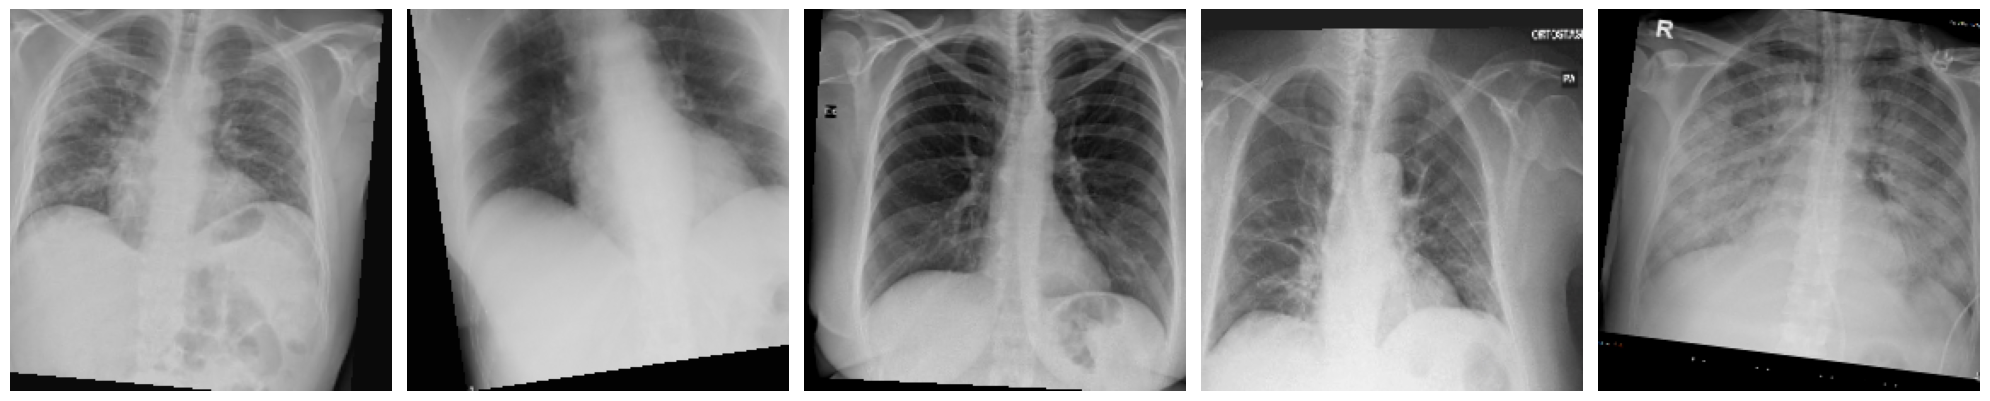

In [5]:
imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)

## Transfer Learning

We took advantage of pre-trained model such as VGG-16 and DenseNet201

We froze all layers in pre-trained model and added 2 fully-connected layers at the end of the model

In [6]:
def get_model(model_name: str):
    if model_name == "VGG-16":
        pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "VGG-19":
        pre_trained_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "Xception":
        pre_trained_model = Xception(weights='imagenet',include_top = False,input_shape = (224,224,3))
    elif model_name == "Inception":
        pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "DenseNet201":
        pre_trained_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "MobileNet":
        pre_trained_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "ResNet152":
        pre_trained_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "ResNet50":
        pre_trained_model = ResNet50(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Invalid model name: {model_name}. Choose from ['VGG-16', 'VGG-19', 'Xception', 'Inception', 'DenseNet201', 'MobileNet', 'ResNet152']")
    return pre_trained_model


In [7]:
# acquire pre-trained model
pre_train_model = get_model("DenseNet201")

# define our own sequential model
model = models.Sequential()
model.add(pre_train_model)
model.add(layers.AveragePooling2D(pool_size=(4,4)))
model.add(layers.Flatten())

# add two fully-connected NN
model.add(layers.Dense(256, activation='relu',name='dense_feature'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['acc'])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-07-12 16:54:37.839973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-12 16:54:37.840111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Train the model

In [8]:
print(f"Number of train batches: {len(train_batches)}")
print(f"Number of valid batches: {len(valid_batches)}")

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

history=model.fit(train_batches,
                steps_per_epoch = STEP_SIZE_TRAIN,
                validation_data = valid_batches,
                validation_steps = STEP_SIZE_VALID,
                epochs= NUM_EPOCHS)

Number of train batches: 7
Number of valid batches: 2
Epoch 1/20


2023-07-12 16:54:42.808676: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-12 16:54:50.763673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.8448 - acc: 0.4773

2023-07-12 16:55:19.445955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 45s 5s/step - loss: 0.8448 - acc: 0.4773 - val_loss: 0.7113 - val_acc: 0.5000
Epoch 2/20
6/6 [==============================] - 3s 389ms/step - loss: 0.5552 - acc: 0.6875 - val_loss: 0.6361 - val_acc: 0.7500
Epoch 3/20
6/6 [==============================] - 6s 502ms/step - loss: 0.4903 - acc: 0.8182 - val_loss: 0.6945 - val_acc: 0.5625
Epoch 4/20
6/6 [==============================] - 4s 598ms/step - loss: 0.3690 - acc: 0.8977 - val_loss: 0.8514 - val_acc: 0.3750
Epoch 5/20
6/6 [==============================] - 2s 383ms/step - loss: 0.2505 - acc: 0.9545 - val_loss: 0.6953 - val_acc: 0.5000
Epoch 6/20
6/6 [==============================] - 2s 390ms/step - loss: 0.1596 - acc: 0.9773 - val_loss: 0.6358 - val_acc: 0.7500
Epoch 7/20
6/6 [==============================] - 4s 599ms/step - loss: 0.1333 - acc: 0.9659 - val_loss: 0.5753 - val_acc: 0.6875
Epoch 8/20
6/6 [==============================] - 3s 395ms/step - loss: 0.0765 - acc: 0.9792 - val_loss

### Plot Accuracy and Loss During Training

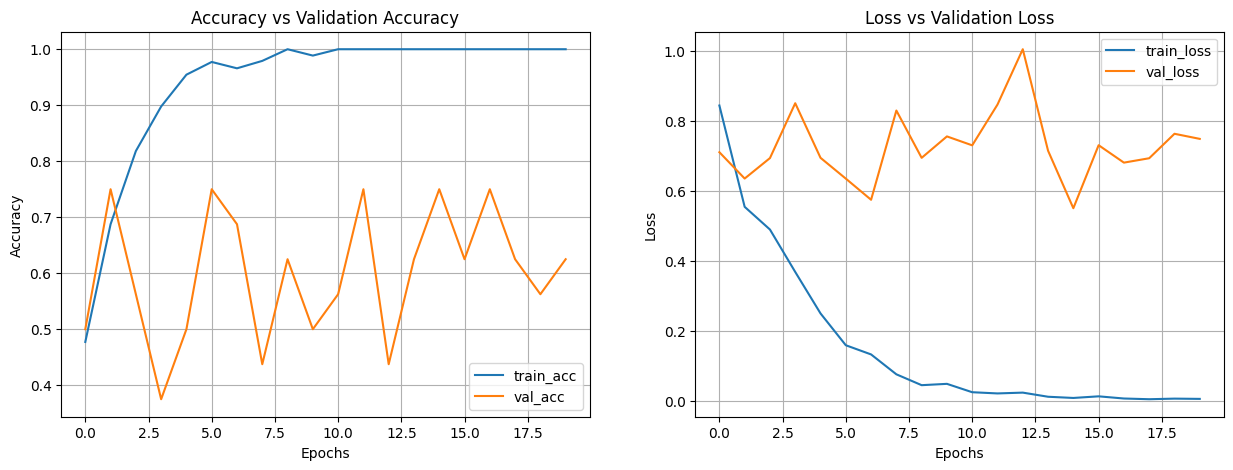

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(model.history.history['acc'], label='train_acc')
plt.plot(model.history.history['val_acc'], label = 'val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Validation Accuracy")
plt.grid(True)
plt.legend(loc='lower right')
plt.subplot(122)
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs Validation Loss")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

### Plot Test Results

Found 18 images belonging to 2 classes.


2023-07-12 16:56:21.792231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 12s 122ms/step
covid/nejmoa2001191_f3-PA.jpeg


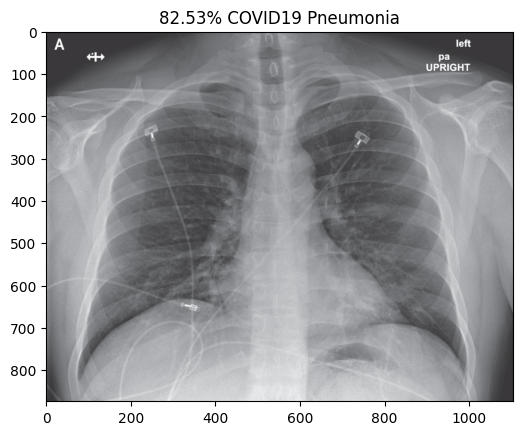

covid/nejmoa2001191_f4.jpeg


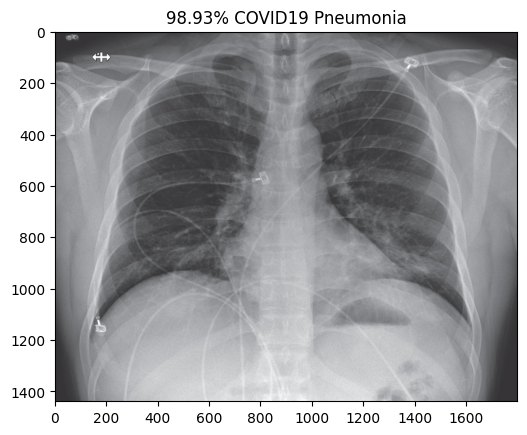

covid/nejmoa2001191_f5-PA.jpeg


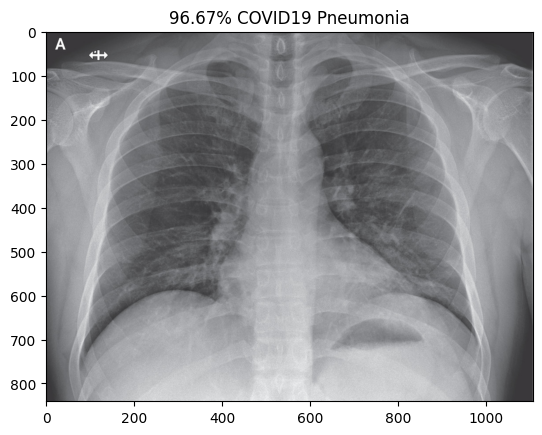

covid/radiol.2020200490.fig3.jpeg


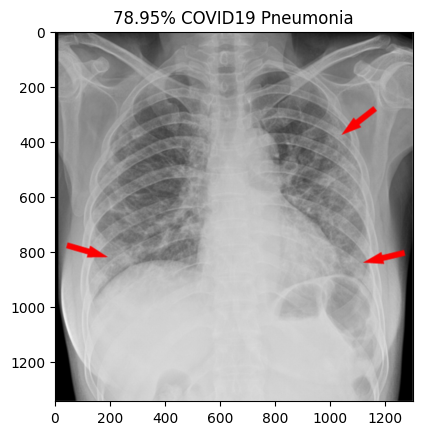

covid/ryct.2020200028.fig1a.jpeg


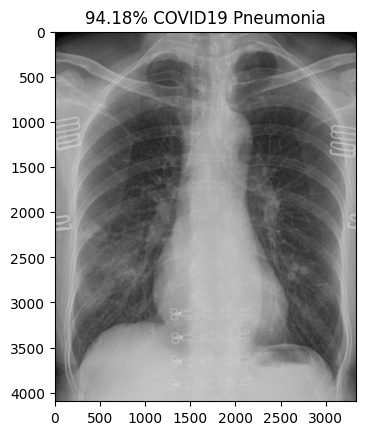

covid/ryct.2020200034.fig2.jpeg


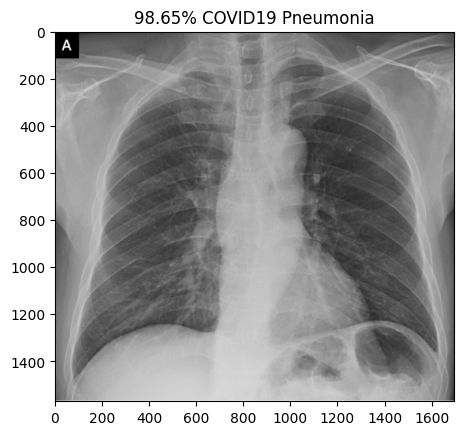

covid/ryct.2020200034.fig5-day0.jpeg


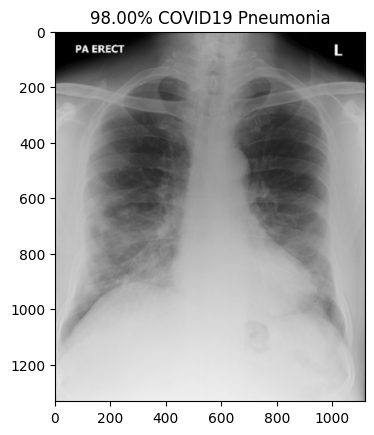

covid/ryct.2020200034.fig5-day4.jpeg


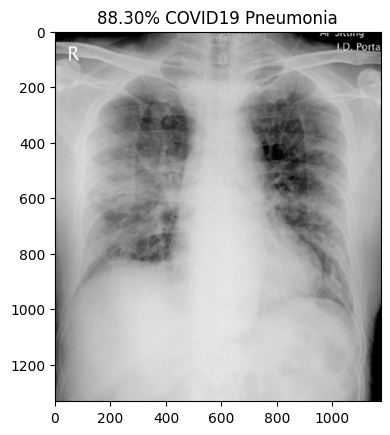

covid/ryct.2020200034.fig5-day7.jpeg


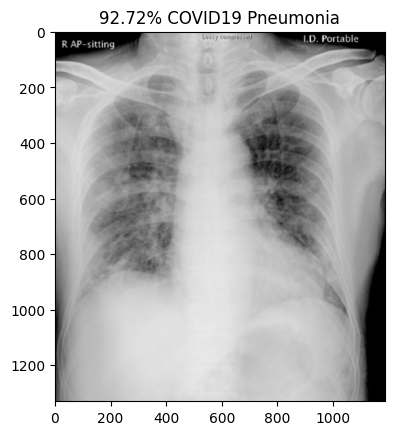

normal/NORMAL2-IM-1385-0001.jpeg


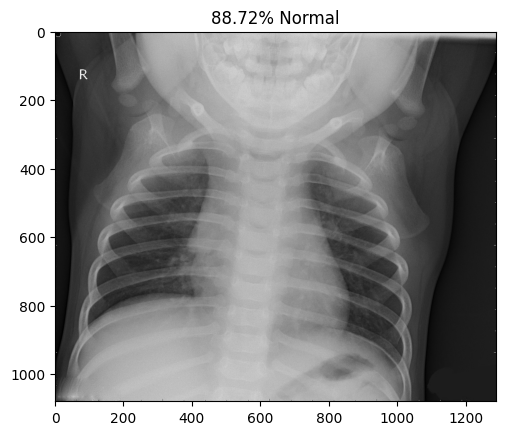

normal/NORMAL2-IM-1396-0001.jpeg


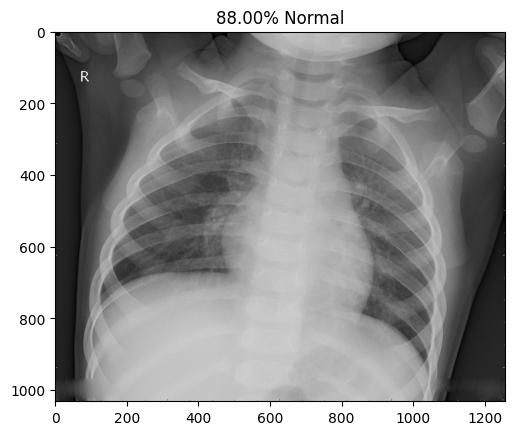

normal/NORMAL2-IM-1400-0001.jpeg


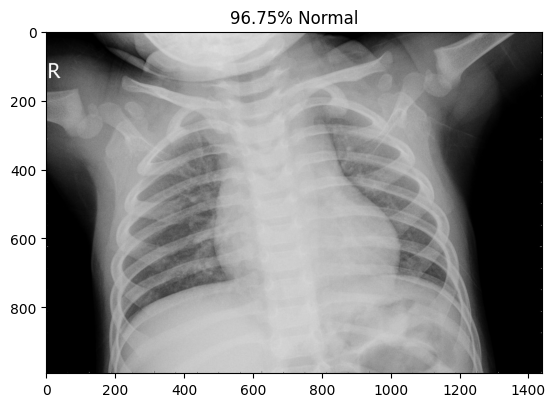

normal/NORMAL2-IM-1401-0001.jpeg


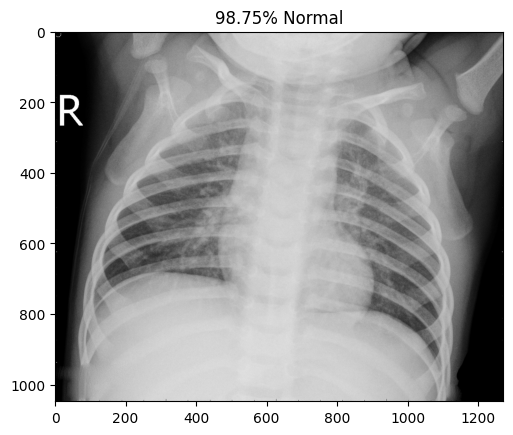

normal/NORMAL2-IM-1406-0001.jpeg


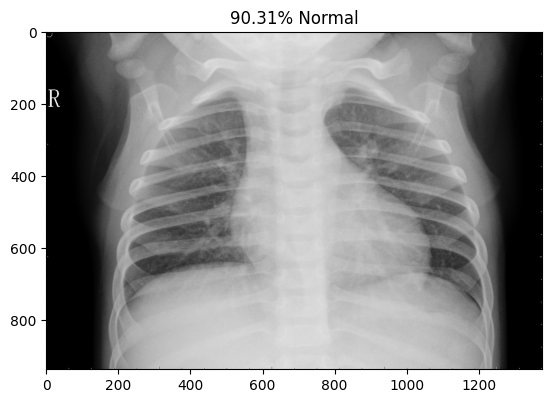

normal/NORMAL2-IM-1412-0001.jpeg


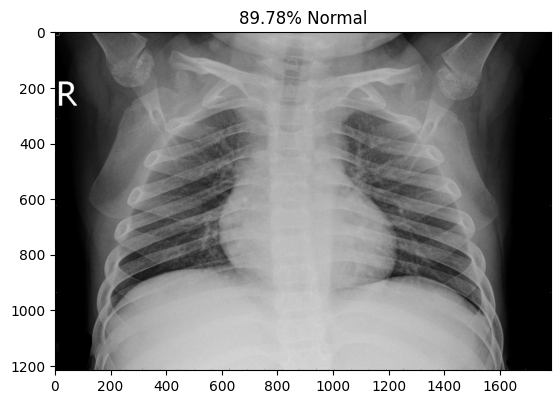

normal/NORMAL2-IM-1419-0001.jpeg


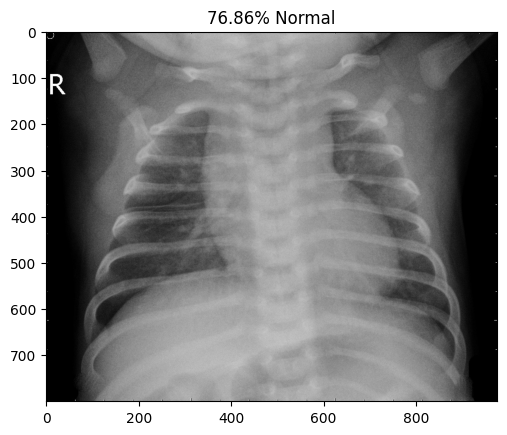

normal/NORMAL2-IM-1422-0001.jpeg


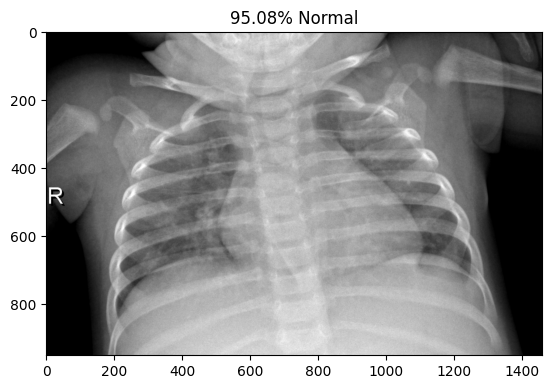

normal/NORMAL2-IM-1423-0001.jpeg


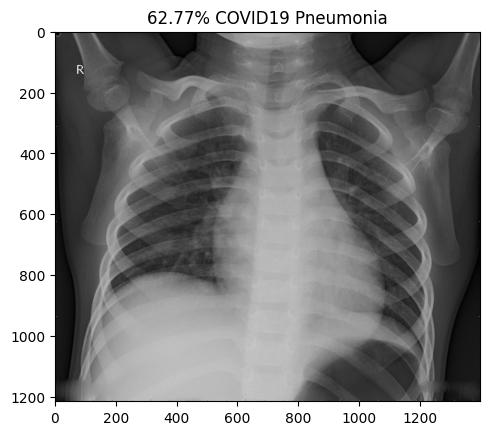

In [10]:
test_datagen = ImageDataGenerator(rescale=1/255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42, class_mode = 'binary')
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)

for index, probability in enumerate(pred):
    # probability = max(probability)
    image_path = TEST_DIR + "/" + eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

In [11]:
test_loss, test_acc = model.evaluate(x = eval_generator, steps=len(eval_generator), batch_size = 1)

18/18 [==============================] - 5s 203ms/step - loss: 0.1429 - acc: 0.9444


In [12]:
predictions = model.predict(x=eval_generator,steps=len(eval_generator), verbose=0)

### Plot the Confusion Matrix

In [13]:
tp, fn, fp, tn = confusion_matrix(y_true=eval_generator.classes,y_pred=np.round(predictions).reshape(-1)).reshape(-1)
cm = confusion_matrix(y_true=eval_generator.classes,y_pred=np.round(predictions))

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_true=eval_generator.classes,y_pred=np.round(predictions).reshape(-1),labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       1.00      0.89      0.94         9
           0       0.90      1.00      0.95         9

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18



In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9 0]
 [1 8]]


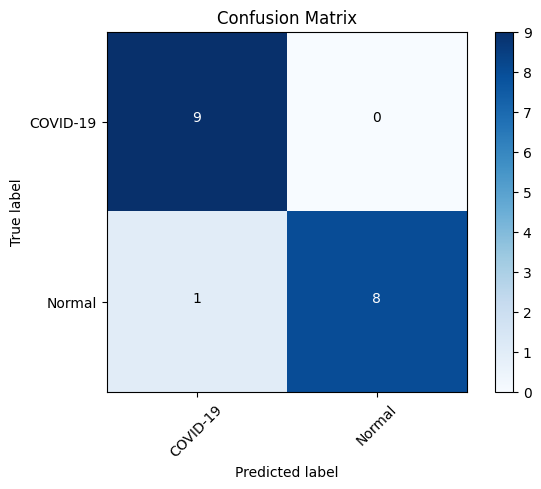

In [15]:
cm_plot_labels = ['COVID-19','Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## TSNE Plot

Examine the image embedding using T-SNE

Found 130 images belonging to 2 classes.
130


2023-07-12 16:56:43.546335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The feature is a  256 dimensional vector


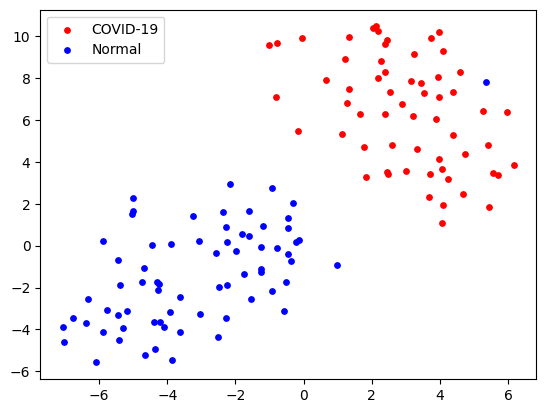

In [16]:
intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_feature').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")


print(len(tsne_data_generator))
feature = intermediate_layer_model.predict_generator(tsne_data_generator,len(tsne_data_generator))
print("The feature is a ", len(feature[0]), "dimensional vector")


labels = np.array([int(tsne_data_generator[i][1][0]) for i in range(len(tsne_data_generator))])

tsne = TSNE(n_components=2, random_state=42)
twoD_rep = tsne.fit_transform(feature)
spec_color = ['r','b']
legends = ['COVID-19','Normal']

for i in range(NUM_CLASSES):
    plt.scatter(twoD_rep[labels == i, 0], twoD_rep[labels == i, 1], 
                marker='o',s=15,c=spec_color[i],label=legends[i])

plt.legend()
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->